#preprocess


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install colorama
import os
import random
import time
from colorama import Fore
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
from PIL import Image
import numpy as np 
###################################
%cd /content/drive/MyDrive/43yolo

###################################
# from model.loss.yolo_loss import YoloV3Loss
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

###################################
# import logging
# import utils.gpu as gpu
# from utils.tools import *
# from utils.visualize import *
# import utils.datasets as data

# from model.yolov3 import Yolov3
# from eval.evaluator import *

from utils import cosine_lr_scheduler
from data.data_prepare import parse_voc_annotation
from data.dataloader import  VocDataset
from model.model import Yolov3
from model.yolo_loss import YoloV3Loss
from visualize.plotting import visulaize_input
from visualize.plotting import  xywh2xyxy
# import config.yolov3_config_voc as cfg
# !pip install tensorboard
# ! pip install tensorboardX


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/drive/.shortcut-targets-by-id/1GMXQdflk8utSMBNupXWVwOc_Wa3PP2-H/43yolo


# parameters

In [3]:
DATA = {"CLASSES":['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
           'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
           'train', 'tvmonitor'],
        "NUM":20}
len(DATA["CLASSES"])
# model
MODEL = {"ANCHORS":[[(1.25, 1.625), (2.0, 3.75), (4.125, 2.875)],  # Anchors for small obj
            [(1.875, 3.8125), (3.875, 2.8125), (3.6875, 7.4375)],  # Anchors for medium obj
            [(3.625, 2.8125), (4.875, 6.1875), (11.65625, 10.1875)]] ,# Anchors for big obj
         "STRIDES":[8, 16, 32],
         "ANCHORS_PER_SCLAE":3
         }

# train
TRAIN = {
         "TRAIN_IMG_SIZE":448,
         "AUGMENT":True,
         "BATCH_SIZE":8,
         "MULTI_SCALE_TRAIN":True,
         "IOU_THRESHOLD_LOSS":0.5,
         "EPOCHS":2,
         "NUMBER_WORKERS":4,
         "MOMENTUM":0.9,
         "WEIGHT_DECAY":0.0005,
         "LR_INIT":1e-4,
         "LR_END":1e-6,
         "WARMUP_EPOCHS":2  # or None
         }


# test
TEST = {
        "TEST_IMG_SIZE":544,
        "BATCH_SIZE":8,
        "NUMBER_WORKERS":0,
        "CONF_THRESH":0.01,
        "NMS_THRESH":0.5,
        "MULTI_SCALE_TEST":False,
        "FLIP_TEST":False
        }

directory = '/content/drive/MyDrive/43yolo'
data_path = '/content/dataset'
result_directory = '/content/drive/MyDrive/43yolo'
#############################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# dataset

## download


In [4]:
%cd /content/
from colorama import Fore
def download_dataset():
  if not os.path.isfile('/content/VOCtrainval_11-May-2012.tar'):
          print(Fore.RED, '.........downloading dataset,this might take several minuet.........')
          print(Fore.BLACK)
          !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
  else:
          print(Fore.BLUE, 'Dataset already exist')


  if not os.path.exists('dataset'):
      os.makedirs('dataset')
  if not os.path.isfile('/content/dataset/VOCdevkit/VOC2012/ImageSets/Action/jumping_train.txt'):
          print(Fore.RED, 'extracting dataset,this might take several minuets......')    
          !tar -xf VOCtrainval_11-May-2012.tar -C dataset
  else:
          print(Fore.BLUE, 'dataset is already extacted')

download_dataset()

/content
 Dataset already exist
 dataset is already extacted


## preprocess

In [5]:
train_annotation_path = os.path.join(directory,'train_ano.txt')
test_annotation_path = os.path.join(directory, 'test_ano.txt')
if not os.path.isfile(train_annotation_path) or not os.path.isfile(test_annotation_path) :
  print(Fore.MAGENTA, 'preparing data..... ')
  print(Fore.BLACK,'--------------------------')
  train_data_path_2012 = os.path.join(data_path,  'VOCdevkit', 'VOC2012')          
  train_data_path_2012 = os.path.join(data_path, 'VOCdevkit', 'VOC2012')
  len_train = parse_voc_annotation(train_data_path_2012, "train", train_annotation_path,  DATA["CLASSES"], use_difficult_bbox=False)
  len_test = parse_voc_annotation(train_data_path_2012, "val", test_annotation_path,DATA["CLASSES"], use_difficult_bbox=False)
  print(Fore.BLACK,'--------------------------')
  print("The number of images for train and test are :train : {0} | test : {1}".format(len_train, len_test))
else :
  print(Fore.MAGENTA, 'prepared data files already exist ')




 prepared data files already exist 




---



---



## data loader

In [6]:
train_dataset = VocDataset(anno_file_type="train", direcory=directory,DATA=DATA,MODEL=MODEL,img_size=448)
train_dataloaer = DataLoader(train_dataset, shuffle=True, batch_size=TRAIN['BATCH_SIZE'], num_workers=0)
test_dataset = VocDataset(anno_file_type="train", direcory=directory,DATA=DATA,MODEL=MODEL,img_size=448)
test_dataloaer = DataLoader(test_dataset, shuffle=True, batch_size=TEST['BATCH_SIZE'], num_workers=0)

## visuling input data

 number of classes in dataset:  20
 ....intput image and label info are as follows....
 img.shape:   torch.Size([8, 3, 448, 448])
 label_sbbox.shape:   torch.Size([8, 56, 56, 3, 26])
 label_mbbox.shape:   torch.Size([8, 28, 28, 3, 26])
 label_lbbox.shape:   torch.Size([8, 14, 14, 3, 26])
 sbboxes.shape:   torch.Size([8, 150, 4])
 mbboxes.shape:   torch.Size([8, 150, 4])
 lbboxes.shape:   torch.Size([8, 150, 4])
 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
 data augmention has been used in training dataset 
 two images are merged in some of the following plot 
 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


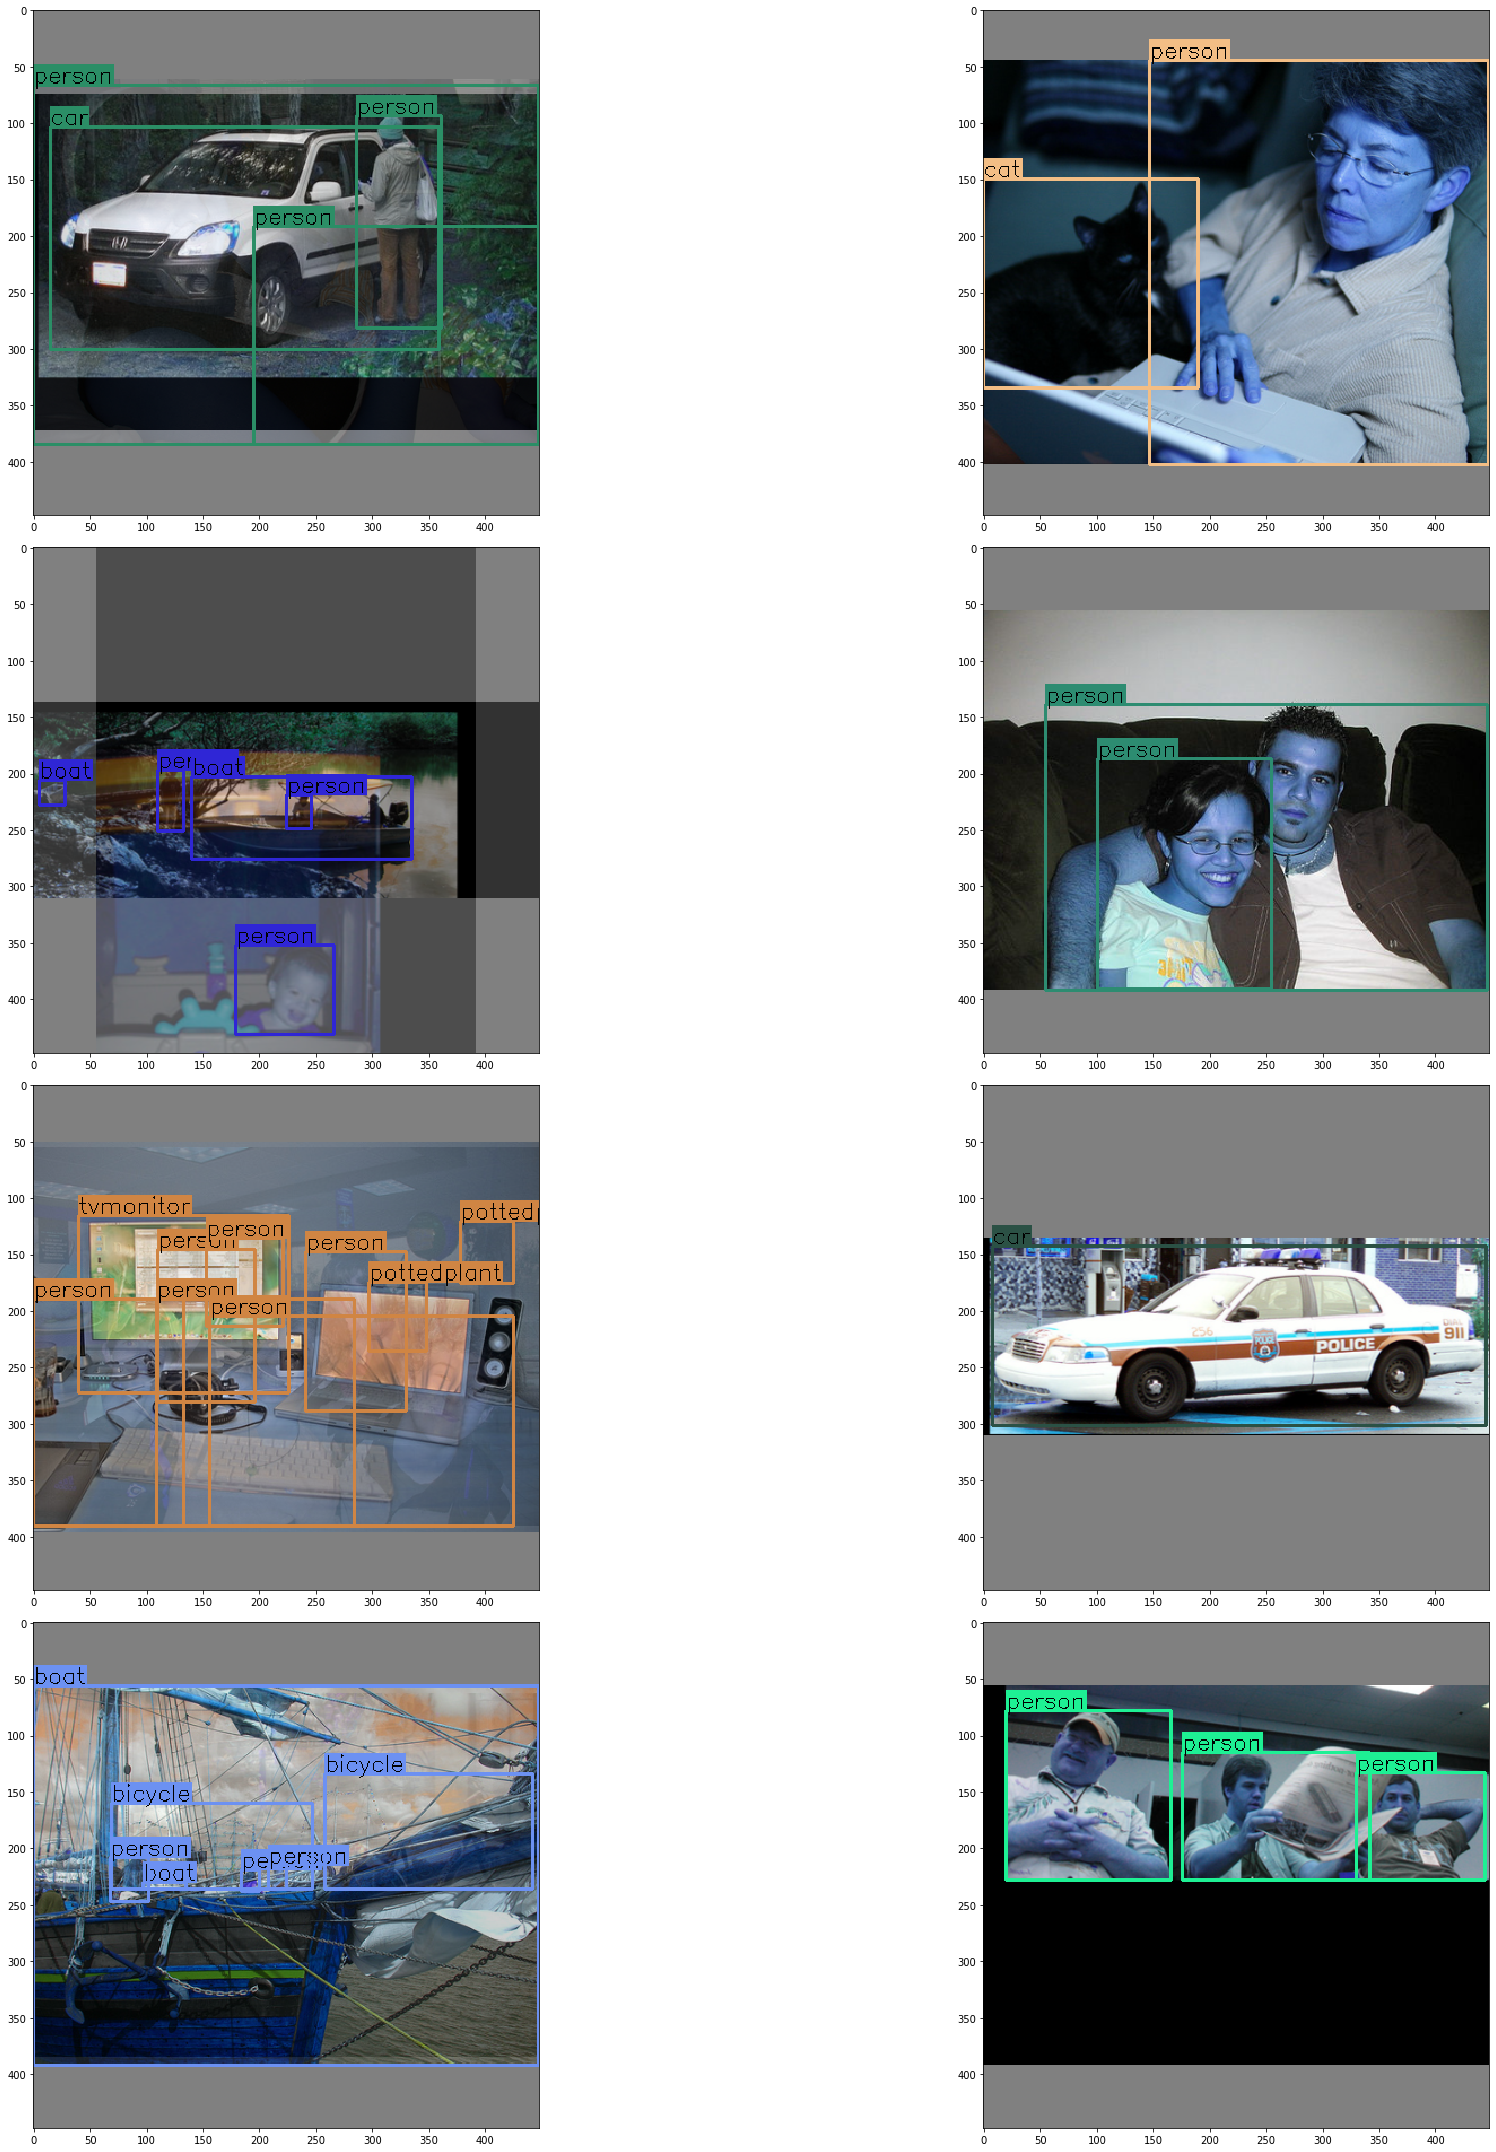

In [7]:
%matplotlib inline
visulaize_input(train_dataloaer,DATA,result_directory)

#model

In [8]:
yolo_model = Yolov3(MODEL,DATA)
yolo_model.to(device)

optimizer = optim.SGD(yolo_model.parameters(), lr=TRAIN["LR_INIT"],
                                   momentum=TRAIN["MOMENTUM"], weight_decay=TRAIN["WEIGHT_DECAY"])

criterion = YoloV3Loss(anchors=MODEL["ANCHORS"], strides=MODEL["STRIDES"],
                                    iou_threshold_loss=TRAIN["IOU_THRESHOLD_LOSS"])

lr_scheduler = cosine_lr_scheduler.CosineDecayLR(optimizer,
                                                          T_max=TRAIN["EPOCHS"]*len(train_dataloaer),
                                                          lr_init=TRAIN["LR_INIT"],
                                                          lr_min=TRAIN["LR_END"],
                                                          warmup=TRAIN["WARMUP_EPOCHS"]*len(train_dataloaer))

initing Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
initing BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
initing BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
initing BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
initing BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
initing BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
initing Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
initing BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

## tensors shape in model

In [9]:
(img, label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes) = next(iter(test_dataloaer ))
img = img.to(device)
label_sbbox = label_sbbox.to(device)
label_mbbox = label_mbbox.to(device)
label_lbbox = label_lbbox.to(device)
sbboxes = sbboxes.to(device)
mbboxes = mbboxes.to(device)
lbboxes = lbboxes.to(device)
"""
        :param p: Predicted offset values for three detection layers.
                    The shape is [p0, p1, p2], ex. p0=[bs, grid, grid, anchors, tx+ty+tw+th+conf+cls_20]
        :param p_d: Decodeed predicted value. The size of value is for image size.
                    ex. p_d0=[bs, grid, grid, anchors, x+y+w+h+conf+cls_20]
        :param label_sbbox: Small detection layer's label. The size of value is for original image size.
                    shape is [bs, grid, grid, anchors, x+y+w+h+conf+mix+cls_20]
        :param label_mbbox: Same as label_sbbox.
        :param label_lbbox: Same as label_sbbox.
        :param sbboxes: Small detection layer bboxes.The size of value is for original image size.
                        shape is [bs, 150, x+y+w+h]
        :param mbboxes: Same as sbboxes.
        :param lbboxes: Same as sbboxes
"""
print(Fore.MAGENTA,'.................in evaluation phase tensors are as follows................. ')
yolo_model.eval()
_ = yolo_model(img,is_visulazing=True)

print(Fore.MAGENTA,'\n\n\n.................in training phase tensors are as follows.................\n\n\n ')
yolo_model.train()
p,p_d = yolo_model(img,is_visulazing=True)





 .................in evaluation phase tensors are as follows................. 
  in darknet neural networks, shapes are as follows: 
         1th layer output: torch.Size([8, 64, 224, 224])
         2th layer output: torch.Size([8, 128, 112, 112])
         3th layer output: torch.Size([8, 128, 112, 112])
         4th layer output: torch.Size([8, 128, 112, 112])
         5th layer output: torch.Size([8, 256, 56, 56])
         6th layer output: torch.Size([8, 256, 56, 56])
         7th layer output: torch.Size([8, 256, 56, 56])
         8th layer output: torch.Size([8, 256, 56, 56])
         9th layer output: torch.Size([8, 256, 56, 56])
         10th layer output: torch.Size([8, 256, 56, 56])
         11th layer output: torch.Size([8, 256, 56, 56])
         12th layer output: torch.Size([8, 256, 56, 56])
         first output
 --------------------
         13th layer output: torch.Size([8, 256, 56, 56])
         14th layer output: torch.Size([8, 512, 28, 28])
         15th layer output:

# train

## train for one epoch

In [10]:
def train_one_epoch( epoch,start_time, EPOCHS=TRAIN["EPOCHS"]):
    mloss = torch.zeros(4)
    for i, (imgs, label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes)  in enumerate(train_dataloaer):

        lr_scheduler.step(len(train_dataloaer)*epoch + i)
        optimizer.zero_grad()

        imgs = imgs.to(device)
        label_sbbox = label_sbbox.to(device)
        label_mbbox = label_mbbox.to(device)
        label_lbbox = label_lbbox.to(device)
        sbboxes = sbboxes.to(device)
        mbboxes = mbboxes.to(device)
        lbboxes = lbboxes.to(device)

        p, p_d = yolo_model(imgs)

        loss, loss_giou, loss_conf, loss_cls = criterion(p, p_d, label_sbbox, label_mbbox,
                                          label_lbbox, sbboxes, mbboxes, lbboxes)
 
        loss.backward()
        optimizer.step()

        # Update running mean of tracked metrics
        loss_items = torch.tensor([loss_giou, loss_conf, loss_cls, loss])
        mloss = (mloss * i + loss_items) / (i + 1)

        # if i>20:
        #   break
        # Print batch results
        if i%5==0 and i!=0:
            end_time = time.time()
            run_time = end_time- start_time 
            s = ('Epoch:(%d / %d, Batch: %d / %d,  time: %.1f     loss_giou: %.4f    loss_conf: %.4f    loss_cls: %.4f    loss: %.4f    '
                  'lr: %g') % (epoch+1, EPOCHS,i, len(train_dataloaer) - 1,run_time, mloss[0],mloss[1], mloss[2], mloss[3],
                              optimizer.param_groups[0]['lr'])
            print(Fore.BLUE,s)

    return(mloss)



## training loop 

In [11]:
%cd /content/drive/MyDrive/43yolo
import os
import shutil
from eval import voc_eval
from utils.datasets import *
from utils.gpu import *
import cv2
import numpy as np
from utils.data_augment import *
import torch
from utils.tools import *
from tqdm import tqdm
from utils.visualize import *



class EVALUATOR(object):
    def __init__(self, model, data_path,PROJECT_PATH,visiual=True):
        self.classes = DATA["CLASSES"]
        self.pred_result_path = os.path.join(PROJECT_PATH,  'result')
        self.val_data_path = os.path.join(data_path , 'VOCdevkit', 'VOC2012')
        self.conf_thresh = TEST["CONF_THRESH"]
        self.nms_thresh = TEST["NMS_THRESH"]
        self.val_shape =  TEST["TEST_IMG_SIZE"]
        self.PROJECT_PATH  = PROJECT_PATH
        self.__visiual = visiual
        self.__visual_imgs = 0

        self.model = model
        self.device = next(model.parameters()).device

    def APs_voc(self, multi_test=False, flip_test=False):
        img_inds_file = os.path.join(self.val_data_path,  'ImageSets', 'Main', 'val.txt')
        with open(img_inds_file, 'r') as f:
            lines = f.readlines()
            img_inds = [line.strip() for line in lines]

        if os.path.exists(self.pred_result_path):
            shutil.rmtree(self.pred_result_path)
        os.mkdir(self.pred_result_path)

        for img_ind in tqdm(img_inds):
            img_path = os.path.join(self.val_data_path, 'JPEGImages', img_ind+'.jpg')
            img = cv2.imread(img_path)
            bboxes_prd = self.get_bbox(img, multi_test, flip_test)

            if bboxes_prd.shape[0]!=0 and self.__visiual and self.__visual_imgs < 100:
                boxes = bboxes_prd[..., :4]
                class_inds = bboxes_prd[..., 5].astype(np.int32)
                scores = bboxes_prd[..., 4]

                visualize_boxes(image=img, boxes=boxes, labels=class_inds, probs=scores, class_labels=self.classes)
                path = os.path.join(self.PROJECT_PATH, "data/results/{}.jpg".format(self.__visual_imgs))
                cv2.imwrite(path, img)

                self.__visual_imgs += 1

            for bbox in bboxes_prd:
                coor = np.array(bbox[:4], dtype=np.int32)
                score = bbox[4]
                class_ind = int(bbox[5])

                class_name = self.classes[class_ind]
                score = '%.4f' % score
                xmin, ymin, xmax, ymax = map(str, coor)
                s = ' '.join([img_ind, score, xmin, ymin, xmax, ymax]) + '\n'

                with open(os.path.join(self.pred_result_path, 'comp4_det_test_' + class_name + '.txt'), 'a') as f:
                    f.write(s)

        return self.__calc_APs()

    def get_bbox(self, img, multi_test=False, flip_test=False):
        if multi_test:
            test_input_sizes = range(320, 640, 96)
            bboxes_list = []
            for test_input_size in test_input_sizes:
                valid_scale =(0, np.inf)
                bboxes_list.append(self.__predict(img, test_input_size, valid_scale))
                if flip_test:
                    bboxes_flip = self.__predict(img[:, ::-1], test_input_size, valid_scale)
                    bboxes_flip[:, [0, 2]] = img.shape[1] - bboxes_flip[:, [2, 0]]
                    bboxes_list.append(bboxes_flip)
            bboxes = np.row_stack(bboxes_list)
        else:
            bboxes = self.__predict(img, self.val_shape, (0, np.inf))

        bboxes = nms(bboxes, self.conf_thresh, self.nms_thresh)

        return bboxes

    def __predict(self, img, test_shape, valid_scale):
        org_img = np.copy(img)
        org_h, org_w, _ = org_img.shape

        img = self.__get_img_tensor(img, test_shape).to(self.device)
        self.model.eval()
        with torch.no_grad():
            _, p_d = self.model(img)
        pred_bbox = p_d.squeeze().cpu().numpy()
        bboxes = self.__convert_pred(pred_bbox, test_shape, (org_h, org_w), valid_scale)

        return bboxes

    def __get_img_tensor(self, img, test_shape):
        img = Resize((test_shape, test_shape), correct_box=False)(img, None).transpose(2, 0, 1)
        return torch.from_numpy(img[np.newaxis, ...]).float()


    def __convert_pred(self, pred_bbox, test_input_size, org_img_shape, valid_scale):
    
        pred_coor = xywh2xyxy(pred_bbox[:, :4])
        pred_conf = pred_bbox[:, 4]
        pred_prob = pred_bbox[:, 5:]

        org_h, org_w = org_img_shape
        resize_ratio = min(1.0 * test_input_size / org_w, 1.0 * test_input_size / org_h)
        dw = (test_input_size - resize_ratio * org_w) / 2
        dh = (test_input_size - resize_ratio * org_h) / 2
        pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
        pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

        pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                    np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)

        invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
        pred_coor[invalid_mask] = 0

        bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
        scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

      
        classes = np.argmax(pred_prob, axis=-1)
        scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
        score_mask = scores > self.conf_thresh

        mask = np.logical_and(scale_mask, score_mask)

        coors = pred_coor[mask]
        scores = scores[mask]
        classes = classes[mask]

        bboxes = np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

        return bboxes


    def __calc_APs(self, iou_thresh=0.5, use_07_metric=False):
 
        filename = os.path.join(self.pred_result_path, 'comp4_det_test_{:s}.txt')
        cachedir = os.path.join(self.pred_result_path, 'cache')
        annopath = os.path.join(self.val_data_path, 'Annotations', '{:s}.xml')
        imagesetfile = os.path.join(self.val_data_path,  'ImageSets', 'Main', 'test.txt')
        APs = {}
        for i, cls in enumerate(self.classes):
            R, P, AP = voc_eval.voc_eval(filename, annopath, imagesetfile, cls, cachedir, iou_thresh, use_07_metric)
            APs[cls] = AP
        if os.path.exists(cachedir):
            shutil.rmtree(cachedir)

        return APs

/content/drive/.shortcut-targets-by-id/1GMXQdflk8utSMBNupXWVwOc_Wa3PP2-H/43yolo


In [ ]:
start_epoch = 0
best_mAP = 0
writer = SummaryWriter()
start_time = time.time()


def save_model_weights( epoch, mAP):

        best_weight = os.path.join(result_directory,'model' ,"best.pt")
       
        chkpt = {'epoch': epoch,
                 'best_mAP': best_mAP,
                 'model': yolo_model.state_dict(),
                 'optimizer': optimizer.state_dict()}
        torch.save(chkpt, best_weight)


for epoch in range(start_epoch, TRAIN["EPOCHS"]):
    yolo_model.train()
    traing_loss = train_one_epoch( epoch,start_time=start_time)
    loss_giou,loss_conf,loss_cls,loss = traing_loss
   

    mAP = 0  
    # yolo_model.eval()    
    with torch.no_grad():
        mloss_test = torch.zeros(4)
        for j, (imgs, label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes)  in enumerate(test_dataloaer):
          # if j>20:
          #   break
          imgs = imgs.to(device)
          label_sbbox = label_sbbox.to(device)
          label_mbbox = label_mbbox.to(device)
          label_lbbox = label_lbbox.to(device)
          sbboxes = sbboxes.to(device)
          mbboxes = mbboxes.to(device)
          lbboxes = lbboxes.to(device)  
          p, p_d = yolo_model(imgs)

          loss_test, loss_giou_test, loss_conf_test, loss_cls_test = criterion(p, p_d, label_sbbox, label_mbbox,label_lbbox, sbboxes, mbboxes, lbboxes)
          loss_items = torch.tensor([loss_giou_test, loss_conf_test, loss_cls_test, loss_test])
          mloss_test = (mloss_test * j + loss_items) / (j + 1)
 
        end_time = time.time()
        run_time = end_time- start_time 
        print(Fore.RED,'test_set loss :')
        s = ('  time: %.1f     loss_giou: %.4f    loss_conf: %.4f    loss_cls: %.4f    loss: %.4f    '
                ) % (run_time, mloss_test[0],mloss_test[1], mloss_test[2], mloss_test[3])
        print(Fore.RED,s)
        loss_giou_test,loss_conf_test,loss_cls_test,loss_test = mloss_test

        writer.add_scalars(f'Loss', {'train_set': loss,'test_set': loss_test}, epoch )
        writer.add_scalars(f'loss_giou', {'train_set':loss_giou,'test_set': loss_giou_test}, epoch )
        writer.add_scalars(f'loss_conf', {'train_set':loss_conf,'test_set': loss_conf_test}, epoch )
        writer.add_scalars(f'loss_cls', {'train_set':loss_cls,'test_set': loss_cls_test}, epoch )
           
        if epoch >= 10:
          APs = EVALUATOR( yolo_model,data_path,directory).APs_voc()
          for i in APs:
              print("{} --> mAP : {}".format(i, APs[i]))
              mAP += APs[i]
          mAP = mAP / len(DATA["CLASSES"])
          print('mAP:%g'%(mAP))

          writer.add_scalar("mAP", mAP, epoch)
          if mAP > best_mAP:
            best_mAP = mAP
          print('best mAP : %g' % (best_mAP))          
        if mAP > best_mAP:
            best_mAP = mAP
            save_model_weights(epoch, mAP)

          
        



writer.flush()
writer.close()

 Epoch:(1 / 2, Batch: 5 / 714,  time: 3.6     loss_giou: 6.8095    loss_conf: 2121.2393    loss_cls: 84.3924    loss: 2212.4412    lr: 3.4965e-07
 Epoch:(1 / 2, Batch: 10 / 714,  time: 6.6     loss_giou: 6.6563    loss_conf: 1872.4675    loss_cls: 82.2279    loss: 1961.3516    lr: 6.99301e-07
 Epoch:(1 / 2, Batch: 15 / 714,  time: 9.7     loss_giou: 7.3741    loss_conf: 1517.0303    loss_cls: 90.6279    loss: 1615.0322    lr: 1.04895e-06
 Epoch:(1 / 2, Batch: 20 / 714,  time: 12.6     loss_giou: 6.7476    loss_conf: 1216.9297    loss_cls: 83.9012    loss: 1307.5784    lr: 1.3986e-06
 Epoch:(1 / 2, Batch: 25 / 714,  time: 14.8     loss_giou: 6.5648    loss_conf: 1000.3431    loss_cls: 81.5443    loss: 1088.4523    lr: 1.74825e-06
 Epoch:(1 / 2, Batch: 30 / 714,  time: 16.9     loss_giou: 6.4284    loss_conf: 845.7701    loss_cls: 80.1637    loss: 932.3622    lr: 2.0979e-06
 Epoch:(1 / 2, Batch: 35 / 714,  time: 19.0     loss_giou: 6.2664    loss_conf: 731.5263    loss_cls: 77.9989    lo

In [ ]:
(img, label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes) = next(iter(train_dataloaer ))
img = img.to(device)
label_sbbox = label_sbbox.to(device)
label_mbbox = label_mbbox.to(device)
label_lbbox = label_lbbox.to(device)
sbboxes = sbboxes.to(device)
mbboxes = mbboxes.to(device)
lbboxes = lbboxes.to(device)
# middle_layer_out = yolo_model(img,is_visulazing =True)

## evaloator

In [ ]:
# def nms(bboxes, score_threshold, iou_threshold, sigma=0.3, method='nms'):

#     classes_in_img = list(set(bboxes[:, 5].astype(np.int32)))
#     best_bboxes = []

#     for cls in classes_in_img:
#         cls_mask = (bboxes[:, 5].astype(np.int32) == cls)
#         cls_bboxes = bboxes[cls_mask]
#         while len(cls_bboxes) > 0:
#             max_ind = np.argmax(cls_bboxes[:, 4])
#             best_bbox = cls_bboxes[max_ind]
#             best_bboxes.append(best_bbox)
#             cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
#             iou = iou_xyxy_numpy(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
#             assert method in ['nms', 'soft-nms']
#             weight = np.ones((len(iou),), dtype=np.float32)
#             if method == 'nms':
#                 iou_mask = iou > iou_threshold
#                 weight[iou_mask] = 0.0
#             if method == 'soft-nms':
#                 weight = np.exp(-(1.0 * iou ** 2 / sigma))
#             cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
#             score_mask = cls_bboxes[:, 4] > score_threshold
#             cls_bboxes = cls_bboxes[score_mask]
#     return np.array(best_bboxes)

In [ ]:

# multi_test = False
# flip_test = False
# ##################
# (img, label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes) = next(iter(test_dataloaer ))
# img = img.to(device)
# label_sbbox = label_sbbox.to(device)
# label_mbbox = label_mbbox.to(device)
# label_lbbox = label_lbbox.to(device)
# sbboxes = sbboxes.to(device)
# mbboxes = mbboxes.to(device)
# lbboxes = lbboxes.to(device)
# yolo_model.eval()
# ###################
# def convert_pred( pred_bbox, test_input_size, org_img_shape, valid_scale,conf_thresh=TEST["CONF_THRESH"]):
    
#         pred_coor = xywh2xyxy(pred_bbox[:,:,:,:, :4])
#         pred_conf = pred_bbox[:,:,:,:, 4]
#         pred_prob = pred_bbox[:,:,:,:, 5:]

#         org_h, org_w = org_img_shape
#         resize_ratio = min(1.0 * test_input_size / org_w, 1.0 * test_input_size / org_h)
#         dw = (test_input_size - resize_ratio * org_w) / 2
#         dh = (test_input_size - resize_ratio * org_h) / 2
#         pred_coor[:,:,:,:, 0::2] = 1.0 * (pred_coor[:,:,:,:, 0::2] - dw) / resize_ratio
#         pred_coor[:,:,:,:, 1::2] = 1.0 * (pred_coor[:,:,:,:, 1::2] - dh) / resize_ratio

#         pred_coor = np.concatenate([np.maximum(pred_coor[:,:,:,:, :2], [0, 0]),
#                                     np.minimum(pred_coor[:,:,:,:, 2:], [org_w - 1, org_h - 1])], axis=-1)

#         invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
#         pred_coor[invalid_mask] = 0

#         bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
#         scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

      
#         classes = np.argmax(pred_prob, axis=-1)
#         scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
#         score_mask = scores >conf_thresh

#         mask = np.logical_and(scale_mask, score_mask)

#         coors = pred_coor[mask]
#         scores = scores[mask]
#         classes = classes[mask]

#         bboxes = np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

#         return bboxes

# ###################
# def predict( img, test_shape, valid_scale):
        
#         org_img = np.copy(img.cpu())
       
#         _,_,org_h, org_w = org_img.shape

#         print('PREDICT')

#         with torch.no_grad():
#             _, p_d = yolo_model(img)
        
#         pred_bbox = p_d[0]
       
#         bboxes = convert_pred(pred_bbox, test_shape, (org_h, org_w), valid_scale)

#         return bboxes
# ########################
# val_shape =  TEST["TEST_IMG_SIZE"]
# if multi_test:
#     test_input_sizes = range(320, 640, 96)
#     bboxes_list = []
#     for test_input_size in test_input_sizes:
#         valid_scale =(0, np.inf)
#         bboxes_list.append(predict(img, test_input_size, valid_scale))
#         if flip_test:
#             bboxes_flip = predict(img[:, ::-1], test_input_size, valid_scale)
#             bboxes_flip[:, [0, 2]] = img.shape[1] - bboxes_flip[:, [2, 0]]
#             bboxes_list.append(bboxes_flip)
#     bboxes = np.row_stack(bboxes_list)
# else:
   
#     bboxes = predict(img, val_shape, (0, np.inf))

# # bboxes_prd = nms(bboxes, conf_thresh, nms_thresh)

In [ ]:
# pred_bbox = p_d[0]
# pred_coor = xywh2xyxy(pred_bbox[:,:,:,:, :4])
# pred_conf = pred_bbox[:,:,:,:, 4]
# pred_prob = pred_bbox[:,:,:,:, 5:]
# org_h, org_w = 448,448
# test_input_size = val_shape
# resize_ratio = min(1.0 * test_input_size / org_w, 1.0 * test_input_size / org_h)

# dw = (test_input_size - resize_ratio * org_w) / 2
# dh = (test_input_size - resize_ratio * org_h) / 2
# pred_coor[:,:,:,:, 0::2] = 1.0 * (pred_coor[:,:,:,:, 0::2] - dw) / resize_ratio
# pred_coor[:,:,:,:, 1::2] = 1.0 * (pred_coor[:,:,:,:, 1::2] - dh) / resize_ratio

# pred_coor = torch.cat([torch.max(pred_coor[:,:,:,:, :2], torch.tensor([0, 0]).to(device)),
#             torch.min(pred_coor[:,:,:,:, 2:], torch.tensor([org_w - 1, org_h - 1]).to(device))], axis=-1)


# invalid_mask = torch.logical_or((pred_coor[:,:,:,:, 0] > pred_coor[:,:,:,:, 2]), (pred_coor[:,:,:,:, 1] > pred_coor[:,:,:,:, 3]))
# pred_coor[invalid_mask] = 0
# pred_coor.shape

In [ ]:
# conf_thresh=TEST["CONF_THRESH"]
# classes = torch.argmax(pred_prob, axis=-1)
# scores = pred_conf .unsqueeze(-1)* pred_prob
# score_mask = scores >conf_thresh


## validation

In [ ]:
# def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None):
#     """Performs Non-Maximum Suppression (NMS) on inference results
#     Returns:
#          detections with shape: nx6 (x1, y1, x2, y2, conf, cls)
#     """

#     nc = prediction.shape[2] - 5  # number of classes

#     # Settings
#     # (pixels) minimum and maximum box width and height
#     max_wh = 4096
#     max_det = 300  # maximum number of detections per image
#     max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
#     time_limit = 1.0  # seconds to quit after
#     multi_label = nc > 1  # multiple labels per box (adds 0.5ms/img)

#     t = time.time()
#     output = [torch.zeros((0, 6), device="cpu")] * prediction.shape[0]

#     for xi, x in enumerate(prediction):  # image index, image inference
#         # Apply constraints
#         # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
#         x = x[x[..., 4] > conf_thres]  # confidence

#         # If none remain process next image
#         if not x.shape[0]:
#             continue

#         # Compute conf
#         x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

#         # Box (center x, center y, width, height) to (x1, y1, x2, y2)
#         box = xywh2xyxy(x[:, :4])

#         # Detections matrix nx6 (xyxy, conf, cls)
#         if multi_label:
#             i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
#             x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
#         else:  # best class only
#             conf, j = x[:, 5:].max(1, keepdim=True)
#             x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

#         # Filter by class
#         if classes is not None:
#             x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

#         # Check shape
#         n = x.shape[0]  # number of boxes
#         if not n:  # no boxes
#             continue
#         elif n > max_nms:  # excess boxes
#             # sort by confidence
#             x = x[x[:, 4].argsort(descending=True)[:max_nms]]

#         # Batched NMS
#         c = x[:, 5:6] * max_wh  # classes
#         # boxes (offset by class), scores
#         boxes, scores = x[:, :4] + c, x[:, 4]
#         i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
#         if i.shape[0] > max_det:  # limit detections
#             i = i[:max_det]

#         output[xi] = to_cpu(x[i])

#         if (time.time() - t) > time_limit:
#             print(f'WARNING: NMS time limit {time_limit}s exceeded')
#             break  # time limit exceeded

#     return output

In [ ]:
# def evaluate_model_file(model_path, weights_path, img_path, class_names, batch_size=8, img_size=416,
#                         n_cpu=8, iou_thres=0.5, conf_thres=0.5, nms_thres=0.5, verbose=True):
#     """Evaluate model on validation dataset.
#     :param model_path: Path to model definition file (.cfg)
#     :type model_path: str
#     :param weights_path: Path to weights or checkpoint file (.weights or .pth)
#     :type weights_path: str
#     :param img_path: Path to file containing all paths to validation images.
#     :type img_path: str
#     :param class_names: List of class names
#     :type class_names: [str]
#     :param batch_size: Size of each image batch, defaults to 8
#     :type batch_size: int, optional
#     :param img_size: Size of each image dimension for yolo, defaults to 416
#     :type img_size: int, optional
#     :param n_cpu: Number of cpu threads to use during batch generation, defaults to 8
#     :type n_cpu: int, optional
#     :param iou_thres: IOU threshold required to qualify as detected, defaults to 0.5
#     :type iou_thres: float, optional
#     :param conf_thres: Object confidence threshold, defaults to 0.5
#     :type conf_thres: float, optional
#     :param nms_thres: IOU threshold for non-maximum suppression, defaults to 0.5
#     :type nms_thres: float, optional
#     :param verbose: If True, prints stats of model, defaults to True
#     :type verbose: bool, optional
#     :return: Returns precision, recall, AP, f1, ap_class
#     """
#     # dataloader = _create_validation_data_loader(
#     #     img_path, batch_size, img_size, n_cpu)
#     # model = load_model(model_path, weights_path)
#     # metrics_output = _evaluate(
#     #     model,
#     #     dataloader,
#     #     class_names,
#     #     img_size,
#     #     iou_thres,
#     #     conf_thres,
#     #     nms_thres,
#     #     verbose)
#     # return metrics_output


# def print_eval_stats(metrics_output, class_names, verbose):
#     if metrics_output is not None:
#         precision, recall, AP, f1, ap_class = metrics_output
#         if verbose:
#             # Prints class AP and mean AP
#             ap_table = [["Index", "Class", "AP"]]
#             for i, c in enumerate(ap_class):
#                 ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
#             print(AsciiTable(ap_table).table)
#         print(f"---- mAP {AP.mean():.5f} ----")
#     else:
#         print("---- mAP not measured (no detections found by model) ----")


# def _evaluate(model, dataloader, class_names, img_size, iou_thres, conf_thres, nms_thres, verbose):
#     """Evaluate model on validation dataset.
#     :param model: Model to evaluate
#     :type model: models.Darknet
#     :param dataloader: Dataloader provides the batches of images with targets
#     :type dataloader: DataLoader
#     :param class_names: List of class names
#     :type class_names: [str]
#     :param img_size: Size of each image dimension for yolo
#     :type img_size: int
#     :param iou_thres: IOU threshold required to qualify as detected
#     :type iou_thres: float
#     :param conf_thres: Object confidence threshold
#     :type conf_thres: float
#     :param nms_thres: IOU threshold for non-maximum suppression
#     :type nms_thres: float
#     :param verbose: If True, prints stats of model
#     :type verbose: bool
#     :return: Returns precision, recall, AP, f1, ap_class
#     """
#     model.eval()  # Set model to evaluation mode

#     Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

#     labels = []
#     sample_metrics = []  # List of tuples (TP, confs, pred)
#     for _, imgs, targets in tqdm.tqdm(dataloader, desc="Validating"):
#         # Extract labels
#         labels += targets[:, 1].tolist()
#         # Rescale target
#         targets[:, 2:] = xywh2xyxy(targets[:, 2:])
#         targets[:, 2:] *= img_size

#         imgs = Variable(imgs.type(Tensor), requires_grad=False)

#         with torch.no_grad():
#             outputs = model(imgs)
#             outputs = non_max_suppression(outputs, conf_thres=conf_thres, iou_thres=nms_thres)

#         sample_metrics += get_batch_statistics(outputs, targets, iou_threshold=iou_thres)

#     if len(sample_metrics) == 0:  # No detections over whole validation set.
#         print("---- No detections over whole validation set ----")
#         return None

#     # Concatenate sample statistics
#     true_positives, pred_scores, pred_labels = [
#         np.concatenate(x, 0) for x in list(zip(*sample_metrics))]
#     metrics_output = ap_per_class(
#         true_positives, pred_scores, pred_labels, labels)

#     print_eval_stats(metrics_output, class_names, verbose)

#     return metrics_output






In [ ]:



for i, (imgs, label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes)  in enumerate(test_dataloaer):


    imgs = imgs.to(device)
    label_sbbox = label_sbbox.to(device)
    label_mbbox = label_mbbox.to(device)
    label_lbbox = label_lbbox.to(device)
    sbboxes = sbboxes.to(device)
    mbboxes = mbboxes.to(device)
    lbboxes = lbboxes.to(device)
    with torch.no_grad():
          p, p_d = yolo_model(imgs,is_training=False)
    if i ==2:
      break



---



---



In [ ]:
# !tensorboard --logdir=/content/runs
%load_ext tensorboard
%tensorboard --logdir /content/runs  --host localhost

In [ ]:

# %load_ext tensorboard
# %tensorboard --logdir {logs_base_dir}

# visualization

## visualize middle layer

## visulaizng output

In [ ]:
(img, label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes) = next(iter(train_dataloaer ))
img = img.to(device)
label_sbbox = label_sbbox.to(device)
label_mbbox = label_mbbox.to(device)
label_lbbox = label_lbbox.to(device)
sbboxes = sbboxes.to(device)
mbboxes = mbboxes.to(device)
lbboxes = lbboxes.to(device)


def convert_pred( pred_bbox, test_input_size , org_img_shape, valid_scale, conf_thresh):
    
        pred_coor = xywh2xyxy(pred_bbox[:, :4])
        pred_conf = pred_bbox[:, 4]
        pred_prob = pred_bbox[:, 5:]

        org_h, org_w = org_img_shape
        resize_ratio = min(1.0 * test_input_size / org_w, 1.0 * test_input_size / org_h)
        dw = (test_input_size - resize_ratio * org_w) / 2
        dh = (test_input_size - resize_ratio * org_h) / 2
        pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
        pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

        pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                    np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)

        invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
        pred_coor[invalid_mask] = 0

        bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
        scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

      
        classes = np.argmax(pred_prob, axis=-1)
        scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
        score_mask = scores > conf_thresh

        mask = np.logical_and(scale_mask, score_mask)

        coors = pred_coor[mask]
        scores = scores[mask]
        classes = classes[mask]

        bboxes = np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

        return bboxes

test_input_sizes = TEST["TEST_IMG_SIZE"]
# org_img = np.copy(img.cpu().data.numpy())
org_h, org_w= img.shape[2],img.shape[3]
yolo_model.eval()
with torch.no_grad():
    _, p_d = yolo_model(torch.unsqueeze(imgs[1,:,:,:], 0))
    pred_bbox = p_d.squeeze().cpu().numpy()
    bboxes = convert_pred(pred_bbox, test_input_sizes,(org_h, org_w),(0, np.inf),conf_thresh =TEST["CONF_THRESH"] )
    
    bboxes = nms(bboxes, TEST["CONF_THRESH"], TEST["NMS_THRESH"])